# **Stanford COVID Vaccine**

OpenVaccine: COVID-19 mRNA Vaccine Degradation Prediction

**Add the necessary libraries**

In [1]:
import os
import warnings

warnings.filterwarnings('ignore')

# the basics
import pandas as pd, numpy as np, seaborn as sns

# data simulation library
from matplotlib import pyplot as plt
from tqdm import tqdm

# for model evaluation
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# A. Overview

mRNA vaccines have taken the lead as the fastest vaccine candidates for COVID-19, but currently, they face key potential limitations. One of the biggest challenges right now is how to design super stable messenger RNA molecules (mRNA). Conventional vaccines (like your seasonal flu shots) are packaged in disposable syringes and shipped under refrigeration around the world, but that is not currently possible for mRNA vaccines.

In [2]:
# get comp data
train = pd.read_json('/kaggle/input/stanford-covid-vaccine/train.json', lines=True)
test = pd.read_json('/kaggle/input/stanford-covid-vaccine/test.json', lines=True)
sample_sub = pd.read_csv('/kaggle/input/stanford-covid-vaccine/sample_submission.csv')

# B. Brief EDA

**Training features are given as follows: [Detail](https://www.kaggle.com/c/stanford-covid-vaccine/data)**

- **id** - An arbitrary identifier for each sample.
- **seq_scored** - (68 in Train and Public Test, 91 in Private Test) Integer value denoting the number of positions used in scoring with predicted values. This should match the length of `reactivity`, `deg_*` and `*_error_*` columns. Note that molecules used for the Private Test will be longer than those in the Train and Public Test data, so the size of this vector will be different.
- **seq_length** - (107 in Train and Public Test, 130 in Private Test) Integer values, denotes the length of `sequence`. Note that molecules used for the Private Test will be longer than those in the Train and Public Test data, so the size of this vector will be different.
- **sequence** - (1x107 string in Train and Public Test, 130 in Private Test) Describes the RNA sequence, a combination of `A`, `G`, `U`, and `C` for each sample. Should be 107 characters long, and the first 68 bases should correspond to the 68 positions specified in `seq_scored` (note: indexed starting at 0).
- **structure** - (1x107 string in Train and Public Test, 130 in Private Test) An array of `(`, `)`, and `.` characters that describe whether a base is estimated to be paired or unpaired. Paired bases are denoted by opening and closing parentheses e.g. (....) means that base 0 is paired to base 5, and bases 1-4 are unpaired.
- **reactivity** - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as `seq_scored`. These numbers are reactivity values for the first 68 bases as denoted in `sequence`, and used to determine the likely secondary structure of the RNA sample.
- **deg_pH10** - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as `seq_scored`. These numbers are reactivity values for the first 68 bases as denoted in `sequence`, and used to determine the likelihood of degradation at the base/linkage after incubating without magnesium at high pH (pH 10).
- **deg_Mg_pH10** - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as `seq_scored`. These numbers are reactivity values for the first 68 bases as denoted in `sequence`, and used to determine the likelihood of degradation at the base/linkage after incubating with magnesium in high pH (pH 10).
- **deg_50C** - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as `seq_scored`. These numbers are reactivity values for the first 68 bases as denoted in `sequence`, and used to determine the likelihood of degradation at the base/linkage after incubating without magnesium at high temperature (50 degrees Celsius).
- **deg_Mg_50C** - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as `seq_scored`. These numbers are reactivity values for the first 68 bases as denoted in `sequence`, and used to determine the likelihood of degradation at the base/linkage after incubating with magnesium at high temperature (50 degrees Celsius).
- **`*_error_*`** - An array of floating point numbers, should have the same length as the corresponding `reactivity` or `deg_*` columns, calculated errors in experimental values obtained in `reactivity` and `deg_*` columns.
- **predicted_loop_type** - (1x107 string) Describes the structural context (also referred to as 'loop type')of each character in `sequence`. Loop types assigned by bpRNA from Vienna RNAfold 2 structure. From the bpRNA_documentation: S: paired "Stem" M: Multiloop I: Internal loop B: Bulge H: Hairpin loop E: dangling End X: eXternal loop

In [3]:
print(train.columns)

Index(['index', 'id', 'sequence', 'structure', 'predicted_loop_type',
       'signal_to_noise', 'SN_filter', 'seq_length', 'seq_scored',
       'reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10',
       'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 'deg_Mg_pH10',
       'deg_pH10', 'deg_Mg_50C', 'deg_50C'],
      dtype='object')


In [4]:
# sneak peak
print(train.shape)
if ~ train.isnull().values.any(): print('No missing values')
train.head()

(2400, 19)
No missing values


,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [5]:
# sneak peak
print(test.shape)
if ~ test.isnull().values.any(): print('No missing values')
test.head()

(3634, 7)
No missing values


,index,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91


In [6]:
# sneak peak
print(sample_sub.shape)
if ~ sample_sub.isnull().values.any(): print('No missing values')
sample_sub.head()

(457953, 6)
No missing values


,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.0,0.0,0.0,0.0,0.0
1,id_00073f8be_1,0.0,0.0,0.0,0.0,0.0
2,id_00073f8be_2,0.0,0.0,0.0,0.0,0.0
3,id_00073f8be_3,0.0,0.0,0.0,0.0,0.0
4,id_00073f8be_4,0.0,0.0,0.0,0.0,0.0


Explore `signal_to_noise` and `SN_filter` distributions. As per the data tab of this competition the samples in `test.json` have been filtered in the following way: [Detail](https://www.kaggle.com/c/stanford-covid-vaccine/data)

1. Minimum value across all 5 conditions must be greater than -0.5.
2. Mean signal/noise across all 5 conditions must be greater than 1.0. [Signal/noise is defined as mean( measurement value over 68 nts )/mean( statistical error in measurement value over 68 nts)]
3. To help ensure sequence diversity, the resulting sequences were clustered into clusters with less than 50% sequence similarity, and the 629 test set sequences were chosen from clusters with 3 or fewer members. That is, any sequence in the test set should be sequence similar to at most 2 other sequences.

But these filters have not been applied to the samples in `train.json` or the private test set of this competition, so we will likely see public leaderboard improvement by filtering `train.json` the same way that `test.json` was filtered.

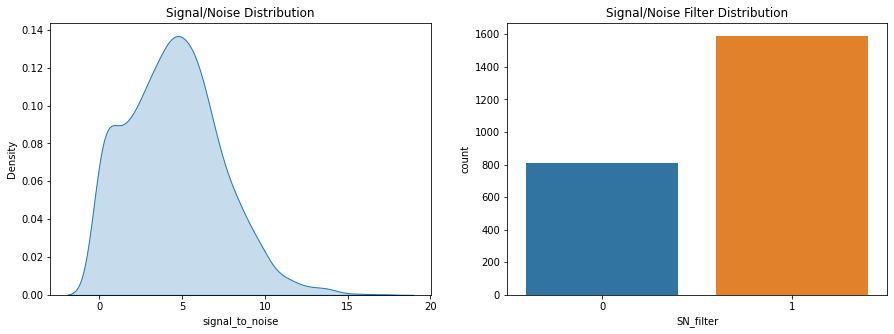

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.kdeplot(train['signal_to_noise'], shade=True, ax=ax[0])
sns.countplot(train['SN_filter'], ax=ax[1])

ax[0].set_title('Signal/Noise Distribution')
ax[1].set_title('Signal/Noise Filter Distribution');

In [8]:
print(f"Samples with signal_to_noise greater than 1: {len(train.loc[(train['signal_to_noise'] > 1)])}")
print(f"Samples with SN_filter = 1: {len(train.loc[(train['SN_filter'] == 1)])}")

Samples with signal_to_noise greater than 1: 2096
Samples with SN_filter = 1: 1589


# C. Processing

In [9]:
# target columns
target_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

tokenize the RNA sequence so it can be feed in my model:

In [10]:
token2int = {x: i for i, x in enumerate('().ACGUBEHIMSX')}

In [11]:
def preprocess_inputs(df, cols=None):
    if cols is None:
        cols = ['sequence', 'structure', 'predicted_loop_type']
    return np.transpose(
        np.array(
            df[cols]
                .applymap(lambda seq: [token2int[x] for x in seq])
                .values
                .tolist()
        ), (0, 2, 1)
    )

In [12]:
train_filtered = train.loc[train.SN_filter == 1]
train_inputs = torch.tensor(preprocess_inputs(train_filtered)).to(device)
print("input shape: ", train_inputs.shape)
train_labels = torch.tensor(
    np.array(train_filtered[target_cols].values.tolist()).transpose(0, 2, 1)
).float().to(device)
print("output shape: ", train_labels.shape)

input shape:  torch.Size([1589, 107, 3])
output shape:  torch.Size([1589, 68, 5])


# D. Model

Note that for submission, the output must be the same length as the input, which is 107 for `train.json` and `test.json` and 130 for the private test set. However, this is not true for training, so training prediction sequences only need to be 68 long.

So actually build 3 different models: one for training, one for predicting public test, and one for predicting private test set, each with different sequence lengths and prediction lengths. Actually, we only need to train one model, save its weights, and load these weights into the other models.

The last thing to set is the size of the embedding layer. Use 100 for now as a starting point:

In [13]:
len(token2int)

14

In [14]:
class GRU_model(nn.Module):
    def __init__(
            self, seq_len=107, pred_len=68, dropout=0.5, embed_dim=100, hidden_dim=128, hidden_layers=3
    ):
        super(GRU_model, self).__init__()
        self.pred_len = pred_len

        self.embeding = nn.Embedding(num_embeddings=len(token2int), embedding_dim=embed_dim)
        self.gru = nn.GRU(
            input_size=embed_dim * 3,
            hidden_size=hidden_dim,
            num_layers=hidden_layers,
            dropout=dropout,
            bidirectional=True,
            batch_first=True,
        )
        self.linear = nn.Linear(hidden_dim * 2, 5)

    def forward(self, seqs):
        embed = self.embeding(seqs)
        reshaped = torch.reshape(embed, (-1, embed.shape[1], embed.shape[2] * embed.shape[3]))
        output, hidden = self.gru(reshaped)
        truncated = output[:, : self.pred_len, :]
        out = self.linear(truncated)
        return out


class LSTM_model(nn.Module):
    def __init__(
            self, seq_len=107, pred_len=68, dropout=0.5, embed_dim=100, hidden_dim=128, hidden_layers=3
    ):
        super(LSTM_model, self).__init__()
        self.pred_len = pred_len

        self.embeding = nn.Embedding(num_embeddings=len(token2int), embedding_dim=embed_dim)
        self.gru = nn.LSTM(
            input_size=embed_dim * 3,
            hidden_size=hidden_dim,
            num_layers=hidden_layers,
            dropout=dropout,
            bidirectional=True,
            batch_first=True,
        )
        self.linear = nn.Linear(hidden_dim * 2, 5)

    def forward(self, seqs):
        embed = self.embeding(seqs)
        reshaped = torch.reshape(embed, (-1, embed.shape[1], embed.shape[2] * embed.shape[3]))
        output, hidden = self.gru(reshaped)
        truncated = output[:, : self.pred_len, :]
        out = self.linear(truncated)
        return out


mse_loss = nn.MSELoss()


def compute_loss(batch_X, batch_Y, model, optimizer=None, is_train=True):
    model.train(is_train)

    pred_Y = model(batch_X)

    loss = mse_loss(pred_Y, batch_Y)

    if is_train:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item()

# E. Training

In [15]:
# basic training configuration
FOLDS = 4
EPOCHS = 90
BATCH_SIZE = 64
VERBOSE = 2
LR = 0.01

In [16]:
# get different test sets and process each
public_df = test.query("seq_length == 107").copy()
private_df = test.query("seq_length == 130").copy()

public_inputs = torch.tensor(preprocess_inputs(public_df)).to(device)
private_inputs = torch.tensor(preprocess_inputs(private_df)).to(device)

public_loader = DataLoader(TensorDataset(public_inputs), shuffle=False, batch_size=BATCH_SIZE)
private_loader = DataLoader(TensorDataset(private_inputs), shuffle=False, batch_size=BATCH_SIZE)

**Add a simple learning rate callback for now:**

## 1. GRU

In [17]:
gru_histories = []
gru_private_preds = np.zeros((private_df.shape[0], 130, 5))
gru_public_preds = np.zeros((public_df.shape[0], 107, 5))

kfold = KFold(FOLDS, shuffle=True, random_state=2020)

for k, (train_index, val_index) in enumerate(kfold.split(train_inputs)):
    train_dataset = TensorDataset(train_inputs[train_index], train_labels[train_index])
    val_dataset = TensorDataset(train_inputs[val_index], train_labels[val_index])

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
    val_loader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE)

    model = GRU_model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    train_losses = []
    val_losses = []
    for epoch in tqdm(range(EPOCHS)):
        train_losses_batch = []
        val_losses_batch = []
        for (batch_X, batch_Y) in train_loader:
            train_loss = compute_loss(batch_X, batch_Y, model, optimizer=optimizer, is_train=True)
            train_losses_batch.append(train_loss)
        for (batch_X, batch_Y) in val_loader:
            val_loss = compute_loss(batch_X, batch_Y, model, optimizer=optimizer, is_train=False)
            val_losses_batch.append(val_loss)
        train_losses.append(sum(train_losses_batch) / len(train_losses_batch))
        val_losses.append(sum(val_losses_batch) / len(val_losses_batch))
    model_state = model.state_dict()
    del model

    gru_histories.append({'train_loss': train_losses, 'val_loss': val_losses})

    gru_short = GRU_model(seq_len=107, pred_len=107).to(device)
    gru_short.load_state_dict(model_state)
    gru_short.eval()
    gru_public_pred = np.ndarray((0, 107, 5))
    for batch in public_loader:
        batch_X = batch[0]
        pred = gru_short(batch_X).detach().cpu().numpy()
        gru_public_pred = np.concatenate([gru_public_pred, pred], axis=0)
    gru_public_preds += gru_public_pred / FOLDS

    gru_long = GRU_model(seq_len=130, pred_len=130).to(device)
    gru_long.load_state_dict(model_state)
    gru_long.eval()
    gru_private_pred = np.ndarray((0, 130, 5))
    for batch in private_loader:
        batch_X = batch[0]
        pred = gru_long(batch_X).detach().cpu().numpy()
        gru_private_pred = np.concatenate([gru_private_pred, pred], axis=0)
    gru_private_preds += gru_private_pred / FOLDS

    del gru_short, gru_long

100%|██████████| 90/90 [01:33<00:00,  1.04s/it]


In [18]:
print(f" GRU mean fold validation loss: {np.mean([min(history['val_loss']) for history in gru_histories])}")

 GRU mean fold validation loss: 0.09007268957793713


## 2. LSTM

In [19]:
lstm_histories = []
lstm_private_preds = np.zeros((private_df.shape[0], 130, 5))
lstm_public_preds = np.zeros((public_df.shape[0], 107, 5))

kfold = KFold(FOLDS, shuffle=True, random_state=2020)

for k, (train_index, val_index) in enumerate(kfold.split(train_inputs)):
    train_dataset = TensorDataset(train_inputs[train_index], train_labels[train_index])
    val_dataset = TensorDataset(train_inputs[val_index], train_labels[val_index])

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
    val_loader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE)

    model = LSTM_model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    train_losses = []
    val_losses = []
    for epoch in tqdm(range(EPOCHS)):
        train_losses_batch = []
        val_losses_batch = []
        for (batch_X, batch_Y) in train_loader:
            train_loss = compute_loss(batch_X, batch_Y, model, optimizer=optimizer, is_train=True)
            train_losses_batch.append(train_loss)
        for (batch_X, batch_Y) in val_loader:
            val_loss = compute_loss(batch_X, batch_Y, model, optimizer=optimizer, is_train=False)
            val_losses_batch.append(val_loss)
        train_losses.append(sum(train_losses_batch) / len(train_losses_batch))
        val_losses.append(sum(val_losses_batch) / len(val_losses_batch))
    model_state = model.state_dict()
    del model

    lstm_histories.append({'train_loss': train_losses, 'val_loss': val_losses})

    lstm_short = LSTM_model(seq_len=107, pred_len=107).to(device)
    lstm_short.load_state_dict(model_state)
    lstm_short.eval()
    lstm_public_pred = np.ndarray((0, 107, 5))
    for batch in public_loader:
        batch_X = batch[0]
        pred = lstm_short(batch_X).detach().cpu().numpy()
        lstm_public_pred = np.concatenate([lstm_public_pred, pred], axis=0)
    lstm_public_preds += lstm_public_pred / FOLDS

    lstm_long = LSTM_model(seq_len=130, pred_len=130).to(device)
    lstm_long.load_state_dict(model_state)
    lstm_long.eval()
    lstm_private_pred = np.ndarray((0, 130, 5))
    for batch in private_loader:
        batch_X = batch[0]
        pred = lstm_long(batch_X).detach().cpu().numpy()
        lstm_private_pred = np.concatenate([lstm_private_pred, pred], axis=0)
    lstm_private_preds += lstm_private_pred / FOLDS

    del lstm_short, lstm_long

100%|██████████| 90/90 [01:46<00:00,  1.19s/it]


In [20]:
print(f" LSTM mean fold validation loss: {np.mean([min(history['val_loss']) for history in lstm_histories])}")

 LSTM mean fold validation loss: 0.05992650892585516


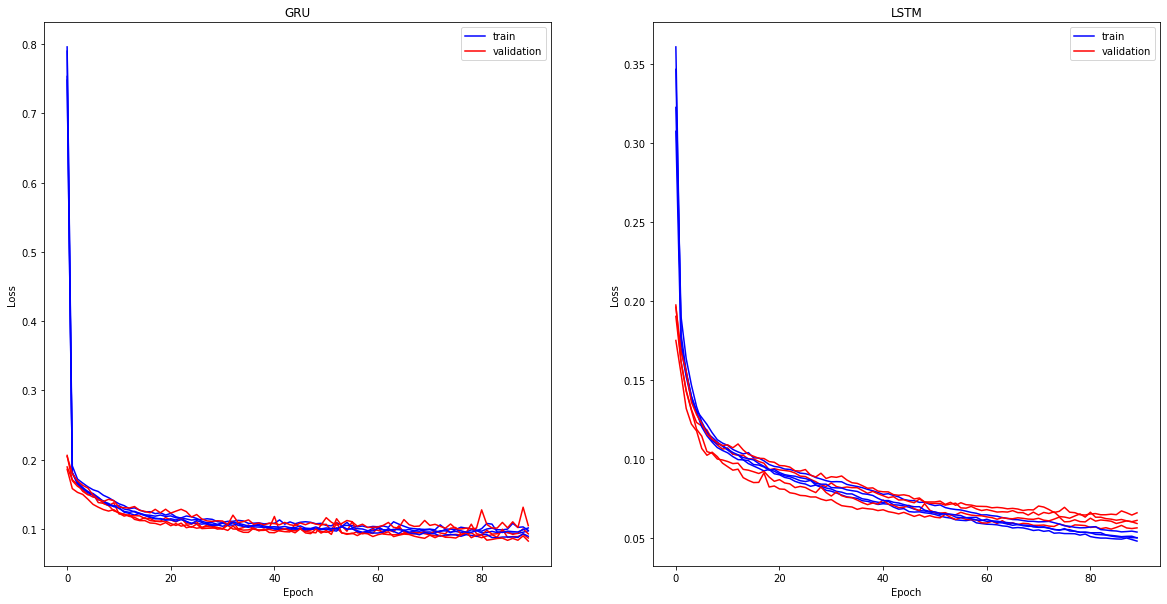

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

for history in gru_histories:
    ax[0].plot(history['train_loss'], 'b')
    ax[0].plot(history['val_loss'], 'r')
for history in lstm_histories:
    ax[1].plot(history['train_loss'], 'b')
    ax[1].plot(history['val_loss'], 'r')

ax[0].set_title('GRU')
ax[1].set_title('LSTM')

ax[0].legend(['train', 'validation'], loc='upper right')
ax[1].legend(['train', 'validation'], loc='upper right')

ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch');

# F. Submission

In [22]:
public_df = test.query("seq_length == 107").copy()
private_df = test.query("seq_length == 130").copy()

public_inputs = preprocess_inputs(public_df)
private_inputs = preprocess_inputs(private_df)

**Just need to change the shape of each sample to long format:**

In [23]:
preds_gru = []

for df, preds in [(public_df, gru_public_preds), (private_df, gru_private_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=target_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_gru.append(single_df)

preds_gru_df = pd.concat(preds_gru)
preds_gru_df.head()

,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,id_seqpos
0,0.743401,0.697540,2.067680,0.552542,0.699264,id_00073f8be_0
1,2.457190,3.553205,4.469412,3.482400,2.840314,id_00073f8be_1
2,1.216492,0.631993,0.820197,0.918975,0.905138,id_00073f8be_2
3,1.279410,1.105466,1.175015,1.354291,1.221545,id_00073f8be_3
4,0.917775,0.699985,0.806467,0.931036,0.894239,id_00073f8be_4


In [24]:
preds_lstm = []

for df, preds in [(public_df, lstm_public_preds), (private_df, lstm_private_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=target_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_lstm.append(single_df)

preds_lstm_df = pd.concat(preds_lstm)
preds_lstm_df.head()

,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,id_seqpos
0,0.879625,0.767891,2.154870,0.605027,0.768817,id_00073f8be_0
1,2.936622,3.757296,4.890235,3.666620,3.053084,id_00073f8be_1
2,1.554308,0.565262,0.730858,0.690977,0.738789,id_00073f8be_2
3,1.354565,1.161131,1.361000,1.713031,1.553826,id_00073f8be_3
4,0.881745,0.699173,0.819848,0.958250,0.923736,id_00073f8be_4


In [25]:
blend_preds_df = pd.DataFrame()
blend_preds_df['id_seqpos'] = preds_gru_df['id_seqpos']
blend_preds_df['reactivity'] = .5 * preds_gru_df['reactivity'] + .5 * preds_lstm_df['reactivity']
blend_preds_df['deg_Mg_pH10'] = .5 * preds_gru_df['deg_Mg_pH10'] + .5 * preds_lstm_df['deg_Mg_pH10']
blend_preds_df['deg_pH10'] = .5 * preds_gru_df['deg_pH10'] + .5 * preds_lstm_df['deg_pH10']
blend_preds_df['deg_Mg_50C'] = .5 * preds_gru_df['deg_Mg_50C'] + .5 * preds_lstm_df['deg_Mg_50C']
blend_preds_df['deg_50C'] = .5 * preds_gru_df['deg_50C'] + .5 * preds_lstm_df['deg_50C']

In [26]:
submission = sample_sub[['id_seqpos']].merge(blend_preds_df, on=['id_seqpos'])

# sanity check
submission.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.811513,0.732715,2.111275,0.578784,0.734041
1,id_00073f8be_1,2.696906,3.655251,4.679823,3.574510,2.946699
2,id_00073f8be_2,1.385400,0.598627,0.775528,0.804976,0.821963
3,id_00073f8be_3,1.316987,1.133298,1.268008,1.533661,1.387685
4,id_00073f8be_4,0.899760,0.699579,0.813157,0.944643,0.908987


In [27]:
submission.to_csv('submission.csv', index=False)
print('Submission saved')

Submission saved
